In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib ipympl
plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['font.size'] = 8
mpl.rc('image', cmap='gray')
import trackpy as tp
tp.quiet()

import numpy as np
import pandas as pd
import csv, json
import pims
from PIL import Image, ImageDraw
import cv2

from scipy.optimize import dual_annealing, linear_sum_assignment
from scipy.spatial import distance_matrix
from tqdm import tqdm
import random

In [96]:
@pims.pipeline
def hough_preprocessing(image, x1, y1, x2, y2):    
    """
    Pims pipeline preprocessing of the image for the HoughCircles function.
    Crops the image to remove the petri dish, converts the image to grayscale and applies a median filter.

    Parameters
    ----------
    image: image
        image to preprocess.
    x1, y1, x2, y2: int
        coordinates of the circle to crop.
    Returns
    -------
    npImage: array
        image to be analyzed.
    """
    npImage = np.array(image)
    #npImage = cv2.cvtColor(npImage, cv2.COLOR_BGR2HSV)
    # Create same size alpha layer with circle
    alpha = Image.new('L', (920, 960), 0)

    draw = ImageDraw.Draw(alpha)
    draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)

    # Convert alpha Image to numpy array
    npAlpha = np.array(alpha)
    npImage = cv2.cvtColor(npImage, cv2.COLOR_BGR2GRAY)*npAlpha #npImage[:, :, 1] * npAlpha
    
    ind = np.where(npImage == 0)
    # npImage[200, 200] color of the border to swap with the black
    npImage[ind] = npImage[200, 200]
    npImage = cv2.medianBlur(npImage, 5)
    return npImage

	
def hough_loc_frame(correct_n, frame, img, parameters):
	"""
	Hough transform to locate the droplets in the frame.

	Parameters
	----------
	correct_n: int
		number of droplets in the frame.
	frame: int
		frame to be analyzed.
	img: image
		image for the HoughCircles function.
	parameters: dict
		parameters for the HoughCircles function.
	
	Returns
	-------
	if found_circles is not None and the number of droplets found is equal to correct_n:
		x, y position of the droplets, diameter of the droplets, frame, correct_n.
	if found_circles is not None and the number of droplets found is not equal to correct_n:
		x, y position (0,0), diameter of the droplets (0), frame, number of droplets found.
	else:
		x, y position (0,0), diameter of the droplets (0), frame, 0.
	"""
	found_circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT_ALT, **parameters)
	return np.hstack((found_circles[0], (np.ones((found_circles.shape[1], 1), dtype=int)*frame),\
						  np.ones((found_circles.shape[1], 1), dtype=int)*found_circles.shape[1]))
	"""
	if (found_circles is not None) and (found_circles.shape[1] == correct_n):
		return np.hstack((found_circles[0], (np.ones((correct_n, 1), dtype=int)*frame),\
						  np.ones((correct_n, 1), dtype=int)*correct_n))
	elif (found_circles is not None) and (found_circles.shape[1] != correct_n):
		return np.hstack((np.zeros((correct_n, 3)), (np.ones((correct_n, 1), dtype=int)*frame),\
						  np.ones((correct_n, 1), dtype=int)*found_circles.shape[1]))
	else:
		return np.hstack((np.zeros((correct_n, 3)), (np.ones((correct_n, 1), dtype=int)*frame),\
						  np.zeros((correct_n, 1), dtype=int)))
	"""

def hough_feature_location(data_preload, fr, startFrame, correct_n, params, progress_verb):
	"""
	Locates the droplets in the frames using the HoughCircles function.
	N.B. Uses cv2.HOUGH_GRADIENT_ALT method, check for the parameters in the OpenCV documentation.

	Parameters
	----------
	data_preload: list
		list of images to be analyzed.
	frames: array
		frames to be analyzed.
	correct_n: int
		number of droplets in the frame.
	params: dict
		parameters for the HoughCircles function.
	progress_verb: bool
		if True, shows the progress bar.

	Returns
	-------
	temp: dataframe
		dataframe with the x, y, d, frame, nDroplets of the found circles in the frames.
	err_frames: array
		frames where the number of droplets found is different from the correct_n.
	loss: float
		percentage of frames where the number of droplets found is different from the correct_n.
	"""
	if progress_verb:
		temp = []
		for i in tqdm(fr):
			temp.append(hough_loc_frame(correct_n, i, data_preload[i-startFrame], params))
	else:
		temp = []
		for i in fr:
			temp.append(hough_loc_frame(correct_n, i , data_preload[i-startFrame], params))

	temp_df = pd.DataFrame(np.concatenate([arr for arr in temp]), columns = ["x", "y", "d", "frame", "nDroplets"])
	temp_df["frame"] = temp_df["frame"].astype(int)
	temp_df["nDroplets"] = temp_df["nDroplets"].astype(int)
	err_frames = temp_df.loc[temp_df.nDroplets != correct_n].frame.unique().astype(int)
	loss = err_frames.shape[0]/frames.shape[0]
	return temp_df, err_frames, loss

def optimize_params(x, *args):
	"""
	Optimizes the parameters for the HoughCircles function and saves the set of parameters with the best score.
	N.B. Uses cv2.HOUGH_GRADIENT_ALT method, check for the parameters in the OpenCV documentation.

	Parameters
	----------
	x: array
		parameters for the HoughCircles function.
	args: tuple
		data_preload, frames, startFrame, correct_n, traj_part.
	
	Returns
	-------
	loss: float
		percentage of frames where the number of droplets found is different from the correct_n.
	"""
	data, frames, startFrame, correct_n, traj_part = args
	params = {"dp":x[0], "minDist":int(x[1]), "param1":x[2], "param2":x[3], "minRadius":int(x[4]), "maxRadius":int(x[5])}
	errs = 0
	for i in frames:#tqdm(frames):
		found_circles = cv2.HoughCircles(data_preload[i-startFrame], cv2.HOUGH_GRADIENT_ALT, **params)
		if (found_circles is not None) and (found_circles.shape[1] == correct_n):
			pass
		else:
			errs += 1
	loss = errs/frames.shape[0]
	
	# Save the current best score and set of parameters to a CSV file
	a = [loss, x[0], int(x[1]), x[2], x[3], int(x[4]), int(x[5])]
	
	with open(f"./results/tracking_data/hough/{traj_part}_opt.csv", mode = 'a', newline='') as file:
	   writer = csv.writer(file)
	   writer.writerow(a)
	print(a)
	return loss
	

def plot_opt_results(opt_result_df):
	"""
	Plots the loss and the parameter slot2.
	
	Parameters
	----------
	opt_result_df: dataframe
		dataframe with the loss and the parameters.
	slot2: str
		parameter to be plotted.
	
	Returns
	-------
	fig: figure
		figure with the loss and the parameter slot2.
	"""
	fig, ax = plt.subplots(1, 1, figsize = (10, 4))
	for slot in opt_result_df.columns:
		ax.plot(np.arange(0, len(opt_result_df)), np.interp(opt_result_df[slot], [opt_result_df[slot].min(), opt_result_df[slot].max()], [0, 1]), label = slot)
	# Shrink current axis by 20%
	box = ax.get_position()
	ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

	# Put a legend to the right of the current axis
	ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
	return fig

In [97]:
# SETUP
preload_load_data = False # takes 20 min
merge_frame = 32269 
traj_part = "pre_merge" # choose which trajectory part to run --> "pre_merge" or "post_merge"
data = hough_preprocessing(pims.open('./data/movie.mp4'), 40, 55, 895, 910)

if traj_part == "pre_merge":
    startFrame = 0
    endFrame = merge_frame
    frames = np.arange(startFrame, endFrame, 1)
    correct_n = 50
    if preload_load_data:
        data_preload_pre_merge = list(data[startFrame:endFrame])
elif traj_part == "post_merge":
    startFrame = merge_frame + 1
    endFrame = len(data)
    frames = np.arange(startFrame, endFrame, 1)
    correct_n = 49
    if preload_load_data: 
        data_preload_post_merge = list(data[startFrame:endFrame])
else:
    raise ValueError("traj_part must be either 'pre_merge' or 'post_merge'")
default_parameters = {"dp": 1.5, "minDist": 15, "param1": 100, "param2": 0.8, "minRadius": 15, "maxRadius": 25}

deprecated pixel format used, make sure you did set range correctly


In [102]:
class TrajectoryProcessing:
    def __init__(self, data_preload, traj_part, frames, correct_n):
        self.traj_part = traj_part
        self.correct_n = correct_n
        self.frames = frames
        self.startFrame = frames[0]
        self.parameters = {"dp": 1.5, "minDist": 15, "param1": 100, "param2": 0.8, "minRadius": 15, "maxRadius": 25}
            
    def parameters_optimization(self, data_preload, nSample, maxfunEvals, run_verb = False, plot_verb=False):
        if run_verb:
            if not os.path.exists(f"./results/tracking_data/hough/{self.traj_part}_opt.csv"):
                # initialize the CSV file with the header if it does not exist
                with open(f"./results/tracking_data/hough/{self.traj_part}_opt.csv", mode='w', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow(['loss', 'dp', 'minDist', 'param1', 'param2', 'minRadius', 'maxRadius'])

            # randomly select nSample frames to optimize --> change this number if needed
            opt_sample = np.sort(random.sample(list(self.frames), nSample)) 
            print(f"Starting optimization on {len(opt_sample)} frames...")
            # paramters of HoughCircles --> dp, minDist, param1, param2, minRadius, maxRadius
            init_guess =  [2, 8, 20, 0.8, 10, 35] # initial guess for the parameters
            params_bounds = [(1, 3), (5, 20), (20, 200), (0.3, 1), (5, 20), (20, 40)] # bounds for the parameters
            
            opt_result = dual_annealing(optimize_params, x0 = init_guess, \
                                        args = (data_preload, opt_sample, startFrame, self.correct_n, self.traj_part),\
                                        bounds = params_bounds, maxfun=maxfunEvals)
            print(opt_result)
            if plot_verb: plot_opt_results(opt_result, self.traj_part)
            self.parameters = {"dp": opt_result.x[0], "minDist": opt_result.x[1], "param1": opt_result.x[2],\
                                        "param2": opt_result.x[3], "minRadius": opt_result.x[4], "maxRadius": opt_result.x[5]}
        else:
            try:
                opt_result_df = pd.read_csv(f"./results/tracking_data/hough/{traj_part}_opt.csv").sort_values("loss", ascending=False)
            except:
                raise Exception("No optimization results found")
            # the best set of parameters is the one that minimizes the loss
            optimized_parameters = {"dp": opt_result_df.iloc[-1].dp, "minDist": opt_result_df.iloc[-1].minDist,\
                                    "param1": opt_result_df.iloc[-1].param1, "param2": opt_result_df.iloc[-1].param2,\
                                    "minRadius": int(opt_result_df.iloc[-1].minRadius), "maxRadius": int(opt_result_df.iloc[-1].maxRadius)}
            self.parameters = optimized_parameters
            display(opt_result_df.tail(19))
            #print("Optimized parameters:", self.parameters)
            if plot_verb: plot_opt_results(opt_result_df)
        

    def run_location_and_linking(self, data_preload, run_verb):
        if run_verb:
            # save to txt parameters:
            with open(f'./results/tracking_data/hough/hough_{traj_part}.txt', 'w') as f:
                f.write(json.dumps(self.parameters))

            print("Running hough feature location...")
            self.hough_df, self.err_frames, self.error = hough_feature_location(data_preload, self.frames, self.correct_n, self.parameters, True)
            self.hough_df.to_parquet(f"./results/tracking_data/hough/hough_{traj_part}.parquet")

            print("Running trackpy linking...")
            self.linked_df = tp.link(self.hough_df, search_range = 150, memory = 2, link_strategy = 'hybrid',\
                                        neighbor_strategy = 'KDTree', adaptive_stop = 1)
            self.linked_df = self.linked_df.sort_values(by=['frame', 'particle'])
            with open('./results/tracking_data/colors.txt', 'r') as filehandle:
                colors = json.load(filehandle)
            c = []
            for p in self.linked_df.particle:
                c.append(colors[p])
            self.linked_df["color"] = c
            self.linked_df.to_parquet(f"./results/tracking_data/hough/linked_{traj_part}.parquet")
        else:
            try:
                self.parameters = json.load(open(f'./results/tracking_data/hough/hough_{traj_part}.txt'))
                self.linked_df = pd.read_parquet(f"./results/tracking_data/hough/linked_{traj_part}.parquet")
            except:
                raise Exception(f"No {traj_part} data found, run analysis first")

"""
# old linking procedure
hough_df = hough_df.replace(0, np.nan)
hough_df.loc[:49, ["frame"]] = 0
if traj_part == "pre_merge":
    correct_n = 50
elif traj_part == "post_merge":
    correct_n = 49
hough_df = hough_df.loc[hough_df.frame.between(0, max(trackpy_df.frame)), :]
hough_df["particle"] = np.ones(len(hough_df), dtype=int)*(-1) # initialize particle id to -1
hough_df["flag"] = np.zeros(len(hough_df), dtype=int) # add flag column to keep record of error frames in which trackpy position 
err_frames = np.where(hough_df.groupby("frame").mean().x.isna())[0] # detect the frames in which hough circle detection failed
link_verb = False
if link_verb:
    print("Starting linking procedure...")
    hough_trackpy_df = hough_df.copy()
    for frame in tqdm(range(max(trackpy_df.frame)+1)):
        # frames with error in hough circle detection --> use trackpy result
        if frame in err_frames:
            # change flag to 1 to denote the fact that trackpy result is used
            hough_trackpy_df.loc[hough_trackpy_df.frame == frame, "flag"] = np.ones(correct_n, dtype=int)
            hough_trackpy_df.loc[hough_trackpy_df.frame == frame, ["x", "y", "frame", "particle"]] = trackpy_df.loc[trackpy_df.frame == frame, ["x", "y", "frame", "particle"]]

        hough_frame = hough_trackpy_df.loc[hough_df.frame == frame]
        trackpy_frame = trackpy_df.loc[trackpy_df.frame == frame]
        # compute distance matrix between hough and trackpy positions
        dist = distance_matrix(hoguh_frame[["x", "y"]].values, trackpy_frame[["x", "y"]].values)
        # solve assignment problem
        row_ind, col_ind = linear_sum_assignment(dist)
        # set particle id in hough_trackpy_df to the one from trackpy
        hough_trackpy_df.loc[hough_trackpy_df.frame == frame, ["particle"]] = trackpy_frame.loc[:, ["particle"]].values[col_ind,:]

    # set colors to hough_trackpy_df
    c = []
    for p in hough_trackpy_df.particle:
        c.append(colors[p])
    hough_trackpy_df["color"] = c
    hough_trackpy_df.sort_values(by=["frame", "particle"], inplace=True)
    hough_trackpy_df = hough_trackpy_df.reset_index().drop(columns=["index"])
    display(hough_trackpy_df)
"""

'\n# old linking procedure\nhough_df = hough_df.replace(0, np.nan)\nhough_df.loc[:49, ["frame"]] = 0\nif traj_part == "pre_merge":\n    correct_n = 50\nelif traj_part == "post_merge":\n    correct_n = 49\nhough_df = hough_df.loc[hough_df.frame.between(0, max(trackpy_df.frame)), :]\nhough_df["particle"] = np.ones(len(hough_df), dtype=int)*(-1) # initialize particle id to -1\nhough_df["flag"] = np.zeros(len(hough_df), dtype=int) # add flag column to keep record of error frames in which trackpy position \nerr_frames = np.where(hough_df.groupby("frame").mean().x.isna())[0] # detect the frames in which hough circle detection failed\nlink_verb = False\nif link_verb:\n    print("Starting linking procedure...")\n    hough_trackpy_df = hough_df.copy()\n    for frame in tqdm(range(max(trackpy_df.frame)+1)):\n        # frames with error in hough circle detection --> use trackpy result\n        if frame in err_frames:\n            # change flag to 1 to denote the fact that trackpy result is used\n

,loss,dp,minDist,param1,param2,minRadius,maxRadius
4,0.010041,2.174076,17,58.999537,0.305645,16,28
41,0.006291,1.984575,8,62.239439,0.421500,16,31
23,0.006167,1.860550,19,104.861481,0.442744,16,29
34,0.003967,1.502978,18,124.209123,0.639808,11,39
83,0.003254,2.430053,7,37.076192,0.794226,14,29
72,0.002634,1.455441,15,101.377009,0.349567,13,25
3,0.002231,2.222772,13,69.048233,0.354341,11,38
51,0.001518,2.816798,10,63.382206,0.818501,11,39
12,0.001518,2.754280,8,78.547444,0.697517,11,34
50,0.001518,2.816798,11,63.382206,0.818501,11,39


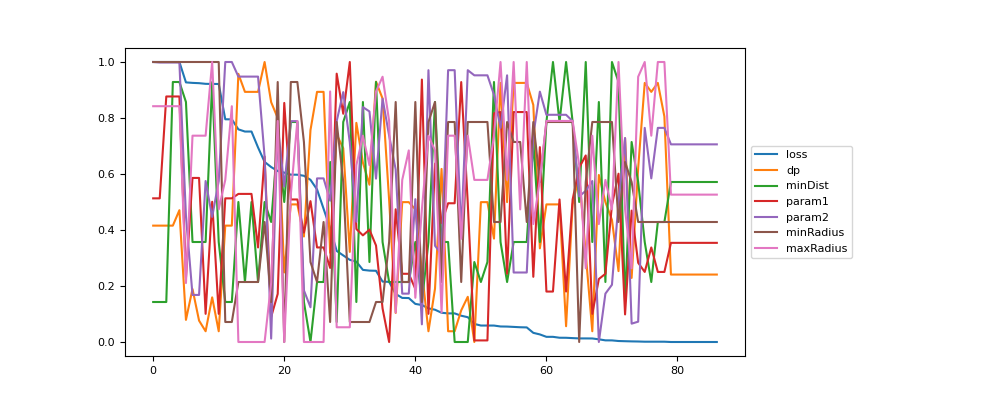

In [103]:
test = TrajectoryProcessing(data_preload, traj_part, frames, correct_n)
test.parameters_optimization(data_preload, 50, 100, run_verb = False, plot_verb=True)
#test.run_location_and_linking(data_preload, True)

In [91]:
def analyze_result(benchmark_traj, df, startFrame, endFrame, benchmark_particle_id):
    confront_traj = df.loc[(df.frame.between(startFrame, endFrame)) & (df.particle == benchmark_particle_id)]
    fig, ax = plt.subplots(1, 1, figsize = (10, 5))
    ax.plot(benchmark_traj.x, benchmark_traj.y, label = "benchmark")
    ax.plot(confront_traj.x, confront_traj.y, label = "confront")
    ax.legend()
    plt.show()

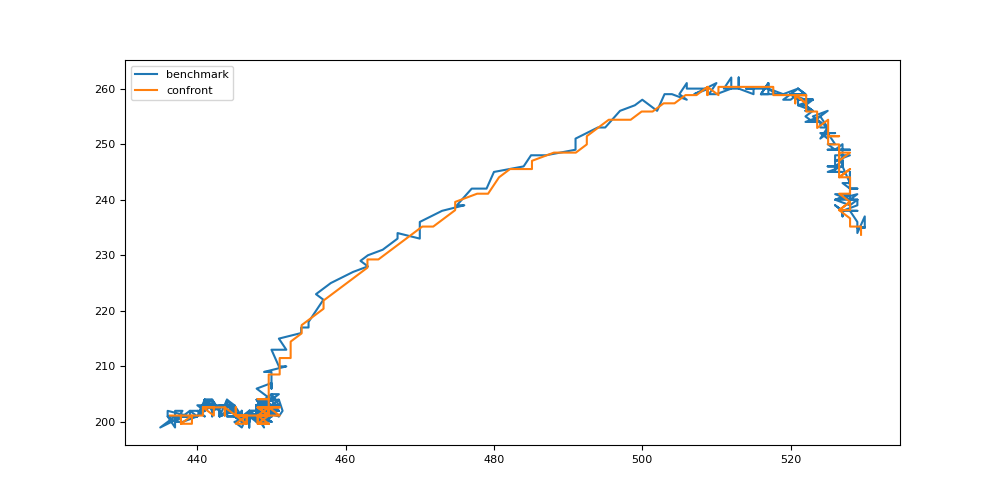

In [92]:
benchmark_traj = pd.read_csv(f"./results/error_estimation/benchmark_traj.csv")
startFrame = 18300
endFrame = 18900 
analyze_result(benchmark_traj, test.linked_df, startFrame, endFrame, 9)

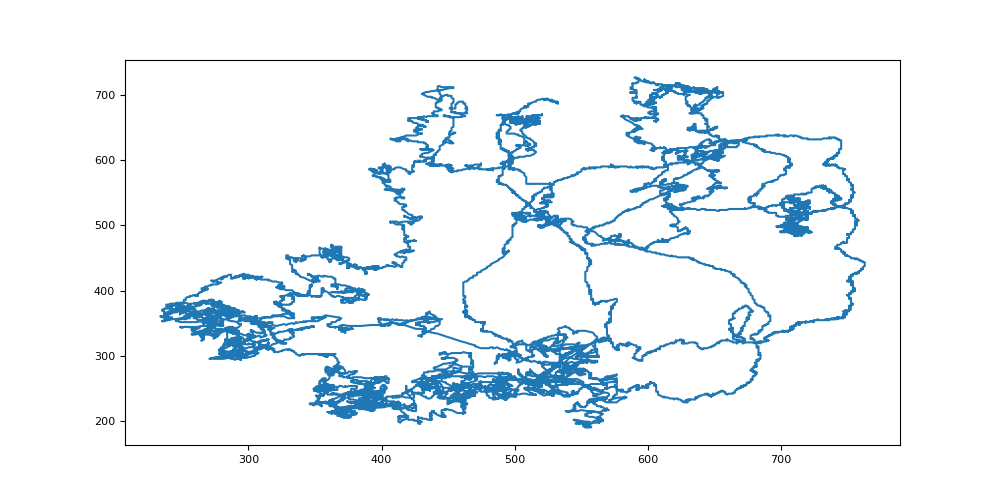

In [54]:
aaaa = test.linked_df.loc[test.linked_df.particle == 0]
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.plot(aaaa.x, aaaa.y)
plt.show()